# 1. Setup

## Install libs

In [45]:
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
nltk.download('stopwords') # run this one time

import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/brad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Grab data

In [46]:
df = pd.read_csv('../data/full_reviews.csv')
df.head()

,Unnamed: 0,text,stars
0,0,"['start', 'I was disappointed to open the package to find 60 individual pods thrown into a large unmarked white box. This product contains the old version of the pods and unlike the description, d...",1
1,1,['start'],1
2,2,"['start', 'I had high expatations and was extremely underwhelmed. And I bought several thinking I would love it. This coffee has disappointed my husband and I and has been placed in the graveyard ...",1
3,3,"['start', 'Peet’s is good coffee when fresh but the pack I bought from Amazon was OLD. “Freshest by” date expired MONTHS AGO.', 'Ridiculously short “best by date.” Received package on December 4, ...",1
4,4,['start'],1


Need to replace 'start' as it was used for scraping only

In [47]:
df['text'] = df['text'].str.replace('start','')
df.head()

,Unnamed: 0,text,stars
0,0,"['', 'I was disappointed to open the package to find 60 individual pods thrown into a large unmarked white box. This product contains the old version of the pods and unlike the description, does n...",1
1,1,[''],1
2,2,"['', 'I had high expatations and was extremely underwhelmed. And I bought several thinking I would love it. This coffee has disappointed my husband and I and has been placed in the graveyard of ba...",1
3,3,"['', 'Peet’s is good coffee when fresh but the pack I bought from Amazon was OLD. “Freshest by” date expired MONTHS AGO.', 'Ridiculously short “best by date.” Received package on December 4, and i...",1
4,4,[''],1


# 2. Preprocessing

## Remove punc and stopwords

In [48]:
# remove unwanted characters, numbers and symbols
df['text'] = df['text'].str.replace("[^a-zA-Z#]", " ")

# remove 'coffee' since it will be most common obvi
df['text'] = df['text'].str.replace("coffee", " ")

In [49]:
stop_words = stopwords.words('english')

# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['text']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

In [50]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

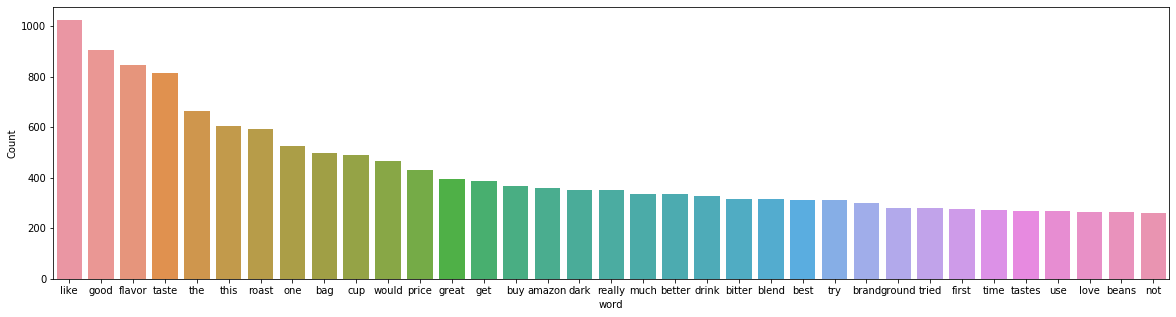

In [51]:
freq_words(reviews, 35)

## Lemmatization with SpaCy lib

In [52]:
!sudo python3 -m spacy download en # one time run

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/brad/.local/lib/python3.6/site-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [53]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

Tokenize the reviews

In [55]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

[]


In [56]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

[]


De-tokenize the lemmatized reviews to see most common words

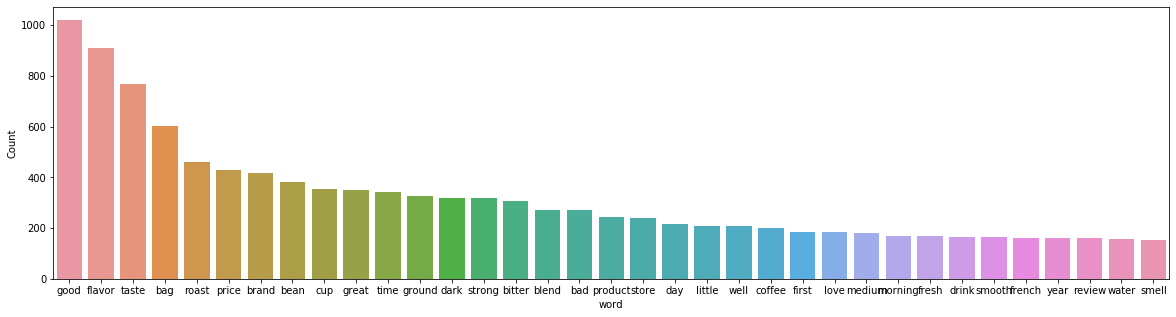

In [57]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 35)

# 3. Build LDA model

In [58]:
dictionary = corpora.Dictionary(reviews_2)

## Doc-term matrix

In [59]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

## Create object for LDA using Gensim

In [60]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [61]:
lda_model.print_topics()

[(0,
  '0.025*"good" + 0.024*"roast" + 0.021*"bag" + 0.020*"bean" + 0.019*"dark" + 0.015*"flavor" + 0.014*"taste" + 0.012*"date" + 0.011*"light" + 0.011*"brand"'),
 (1,
  '0.022*"cold" + 0.018*"good" + 0.018*"brew" + 0.013*"water" + 0.012*"cup" + 0.011*"caffeine" + 0.011*"ground" + 0.011*"strong" + 0.010*"bag" + 0.010*"taste"'),
 (2,
  '0.033*"flavor" + 0.032*"good" + 0.026*"taste" + 0.014*"price" + 0.014*"bag" + 0.013*"great" + 0.012*"brand" + 0.012*"roast" + 0.009*"time" + 0.009*"strong"'),
 (3,
  '0.025*"good" + 0.018*"taste" + 0.015*"flavor" + 0.012*"decaf" + 0.011*"bitter" + 0.010*"drink" + 0.010*"coffee" + 0.009*"bad" + 0.009*"great" + 0.008*"hazelnut"'),
 (4,
  '0.024*"bag" + 0.017*"bean" + 0.017*"good" + 0.015*"price" + 0.014*"colombian" + 0.014*"whole" + 0.012*"roast" + 0.012*"flavor" + 0.012*"bitter" + 0.011*"taste"'),
 (5,
  '0.017*"ground" + 0.008*"good" + 0.008*"flavor" + 0.008*"thing" + 0.006*"rating" + 0.006*"disappointed" + 0.006*"time" + 0.006*"brand" + 0.006*"bad" + 0

# 4. Viz the topics

In [62]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.068593 -0.031025       1        1  56.004818
0     -0.084727 -0.034498       2        1  16.205008
6     -0.059083 -0.088961       3        1  13.415659
1     -0.009745  0.119561       4        1   6.080215
4     -0.059387  0.073919       5        1   5.284638
3      0.133680 -0.071496       6        1   1.980442
5      0.147856  0.032500       7        1   1.029226, topic_info=        Term        Freq       Total Category  logprob  loglift
42      good  957.000000  957.000000  Default  30.0000  30.0000
44    ground  298.000000  298.000000  Default  29.0000  29.0000
36    flavor  865.000000  865.000000  Default  28.0000  28.0000
214    taste  725.000000  725.000000  Default  27.0000  27.0000
137      bag  561.000000  561.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
168    light    1.112311  136.283310   Topic7  -5.8009  -0.2319
6        box    1.090151  114.304527   Topic7  -5.8211  -0.0762
153      fan    1.068871   46.197353   Topic7  -5.8408   0.8100
95   product    1.098867  229.892609   Topic7  -5.8131  -0.7670
214    taste    1.118498  725.093689   Topic7  -5.7954  -1.8980

[581 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
272       1  0.489068  able
272       2  0.209601  able
272       3  0.209601  able
272       4  0.046578  able
272       6  0.069867  able
...     ...       ...   ...
228       2  0.198069  year
228       3  0.118842  year
228       5  0.059421  year
228       6  0.019807  year
228       7  0.006602  year

[1059 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 7, 2, 5, 4, 6])

Reference article: [Analytics Vidya](https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/)